# Loading the VGG-19 model
VGG19 is a19-layer version of the VGG network, with weights pre-trained on ImageNet and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers) . ImageNet is a dataset of over 15 million labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000
categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.
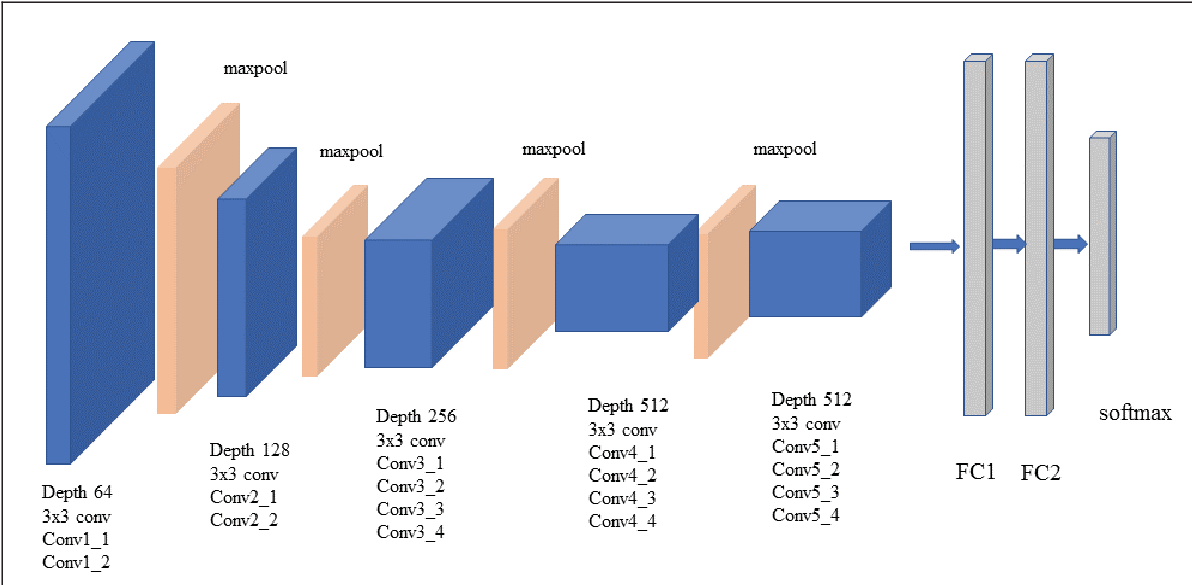

We are not using the VGG-19 for classification but only for feature extraction

In [ ]:
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

In [ ]:
def load_pretrained_model():
    vgg19 = models.vgg19(pretrained=True).features
    for param in vgg19.parameters():
        param.requires_grad_(False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg19.to(device)
    return vgg19, device

#Converting Images into a Tensor
Defining a function procImg that preprocesses images for neural style transfer. It reads the image, converts it to RGB format, resizes it to a specified maximum size, applies a series of image transformations (**resizing**, converting to tensor, and **normalizing**), and adds an extra dimension to the tensor. The function is then called to process both the content and style images. Finally, the processed images are moved to the specified device (CPU or GPU) and their shapes are printed.

In [ ]:
def process_image(img_path, max_size=500):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = img_transforms(image).unsqueeze(0)
    return image


#Converting Tensor back into an Image
Defining a function deprocImg that converts preprocessed image tensors back to their original format, applies image **denormalization**, and visualizes the content and style images using Matplotlib.

In [ ]:
def deprocess_image(tensor):
    image = tensor.to('cpu').clone()
    image = image.numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    return image


#Getting Feature Representations for a Layer of Interest
The "featureExtract" function takes an image tensor and a pre-trained VGG-19 model as input and extracts feature maps from the image at specific layers of the model. The function maintains a dictionary to map layer names to the corresponding feature maps. It iterates over the model's named modules, applies each layer to the input image, and stores the feature maps from selected layers in the dictionary. Finally, it returns the dictionary of extracted feature maps.

In [ ]:
def extract_features(image, model):
    layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


 # Calculating the Gram-Matrix

 It is a matrix comprising of correlated features. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image. If the feature map is a matrix F, then each entry in the Gram matrix G can be given by:

!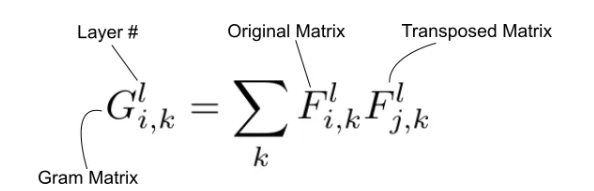

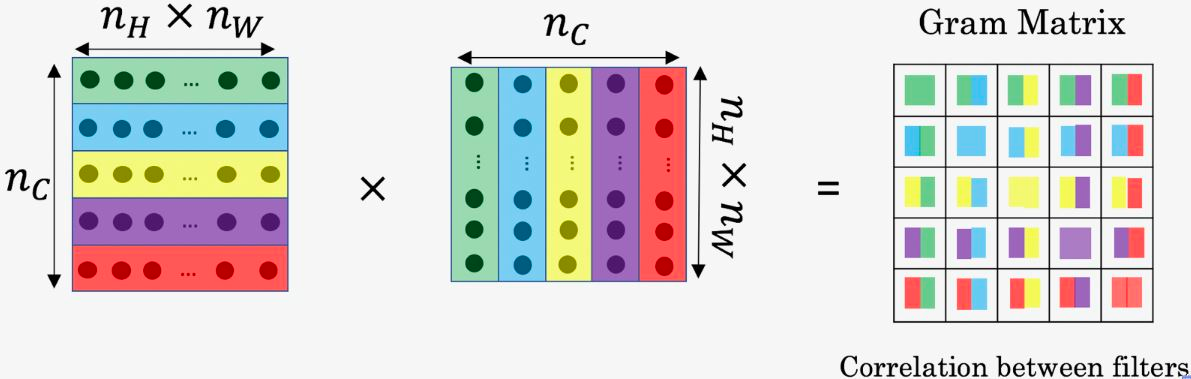

In [ ]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

#Loss Functions :
 **Loss functions** inform the accuracy of a model. The lower the loss the higher the accuracy.

i) **Content Loss**: It is used to check how much the generated image is similar to our content image. We know that the information about the content of any image will be simply given by the activations of the neurons in different layers. The deeper the layer, the more information it stores. It is calculated as the euclidean distance between the activations or feature representation of content and generated images at different layers. The formula for Content Loss is given below.

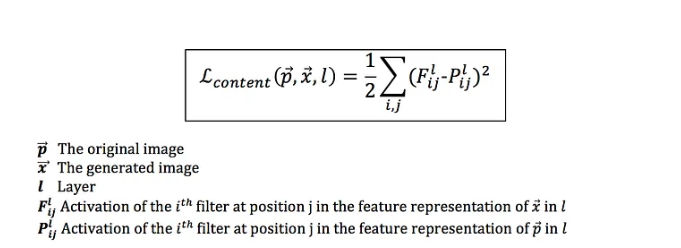

ii) **Style Loss**: Similar to content loss, Style Loss is used to check how much the style of the generated image differs from the style of my style image. But the difference between both is that the style of any image is not simply represented as in the case of content.We can get the style representation of any image using the Gram Matrix.

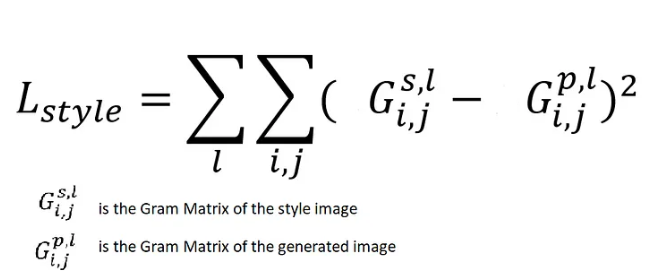


**TOTAL LOSS** is the weighted sum of these 2 losses. These weights decide how much impact will style or content will have on the total loss. If you want to have more style than content in the resultant image, put a higher weight on the style loss which makes the total_loss to be more dependent on style loss and optimizing total_loss will focus more on optimizing style loss. Hence, making the resultant image more similar to style image than content image.

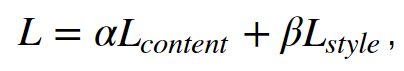

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
    loss = torch.mean((target_conv4_2 - content_conv4_2) ** 2)
    return loss

def style_loss(style_weights, target_features, style_grams):
    loss = 0
    for layer in style_weights:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]
        b, c, h, w = target_f.shape
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss / (c * h * w)
    return loss

def total_loss(content_loss, style_loss, alpha, beta):
    loss = alpha * content_loss + beta * style_loss
    return loss

#Optimization Algorithm

Weight for Content Loss : **alpha**

Weight for Style Loss : **beta**


**Optimization Algorithm**
It’s a way to minimize (or maximize) a function. Since we have a total loss function that is dependent on the combination image, the optimization algorithm will tell us how to change the combination image to make the loss a bit smaller.

I chose the **Adam optimizer** for the task due to its adaptive learning rates, which help handle different feature types in content and style images efficiently. The incorporation of momentum accelerates convergence, and Adam's efficiency with sparse gradients aligns well with the complex optimization landscape of style transfer tasks.


In [ ]:
def run_style_transfer(content_path, style_path, alpha=1, beta=1e5, epochs=5000, tracker=500, lr=0.05):
    vgg19, device = load_pretrained_model()

    content_image = process_image(content_path).to(device)
    style_image = process_image(style_path).to(device)

    content_features = extract_features(content_image, vgg19)
    style_features = extract_features(style_image, vgg19)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
    target_image = content_image.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([target_image], lr=lr)

    results = []

    for i in range(epochs):
        target_features = extract_features(target_image, vgg19)
        c_loss = content_loss(target_features['conv4_2'], content_features['conv4_2'])
        s_loss = style_loss(style_weights, target_features, style_grams)
        t_loss = total_loss(c_loss, s_loss, alpha, beta)

        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()

        if i % tracker == 0:
            print('Epoch #{}, Loss: {:.2f}'.format(i, t_loss.item()))
            results.append(deprocess_image(target_image.detach()))

    final_image = results[-1]  # Assuming the last image in 'results' is the final generated image

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(deprocess_image(content_image.detach()))
    axes[0].set_title('Content Image')
    axes[0].axis('off')

    axes[1].imshow(deprocess_image(style_image.detach()))
    axes[1].set_title('Style Image')
    axes[1].axis('off')

    axes[2].imshow(final_image)
    axes[2].set_title('Stylized Image')
    axes[2].axis('off')

    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 102MB/s]


Epoch #0, Loss: 861826688.00
Epoch #500, Loss: 2208788.50
Epoch #1000, Loss: 800174.50
Epoch #1500, Loss: 406072.81
Epoch #2000, Loss: 247132.75
Epoch #2500, Loss: 181688.47
Epoch #3000, Loss: 186351.48
Epoch #3500, Loss: 371083.41
Epoch #4000, Loss: 90961.95
Epoch #4500, Loss: 81080.85


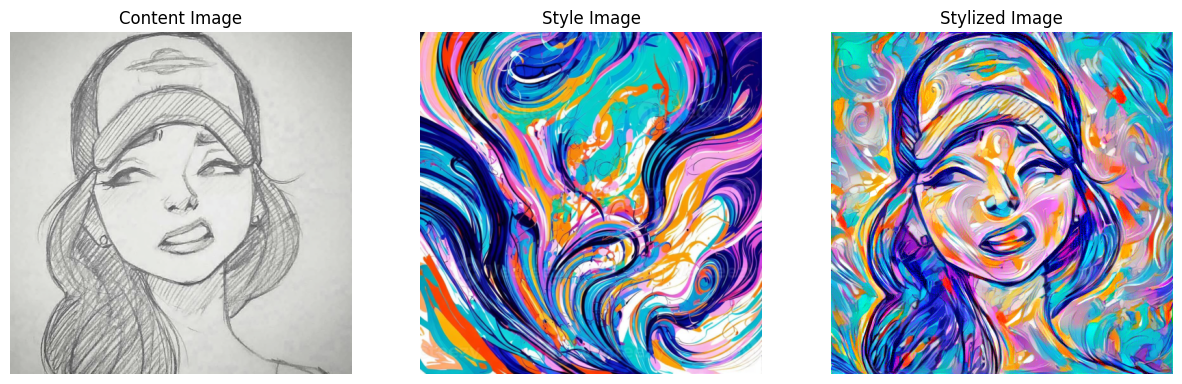

In [ ]:
run_style_transfer('/content1.jpg', '/style1.jpg')

Epoch #0, Loss: 491406240.00
Epoch #500, Loss: 572488.75
Epoch #1000, Loss: 208426.59
Epoch #1500, Loss: 129193.30
Epoch #2000, Loss: 543372.88
Epoch #2500, Loss: 85055.07
Epoch #3000, Loss: 68727.02
Epoch #3500, Loss: 70508.97
Epoch #4000, Loss: 68495.54
Epoch #4500, Loss: 53916.85


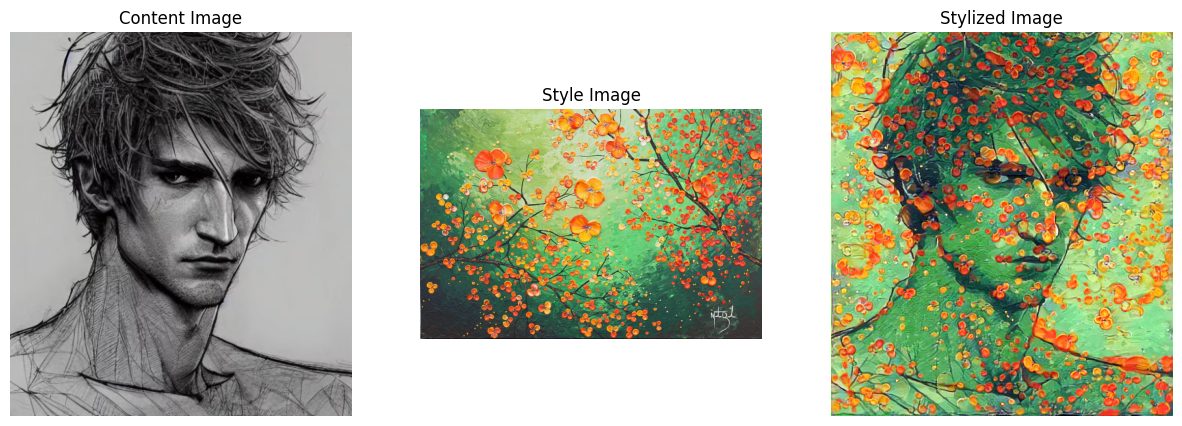

In [ ]:
run_style_transfer('/content2.jpeg', '/style2.jpeg')

Epoch #0, Loss: 69192440.00
Epoch #500, Loss: 44019.21
Epoch #1000, Loss: 14110.34
Epoch #1500, Loss: 8559.36
Epoch #2000, Loss: 8538.98
Epoch #2500, Loss: 11558.40
Epoch #3000, Loss: 12569.91
Epoch #3500, Loss: 7693.63
Epoch #4000, Loss: 4848.43
Epoch #4500, Loss: 5784.93


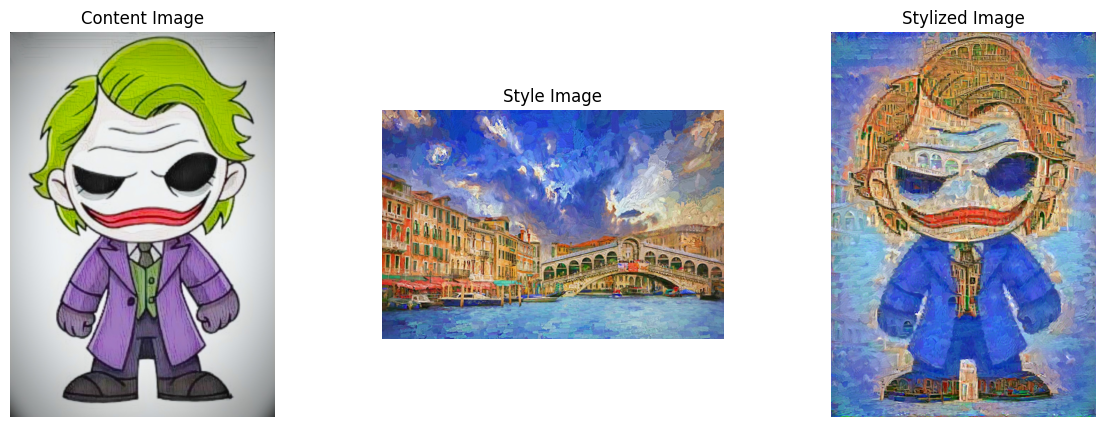

In [ ]:
run_style_transfer('/content3.jpeg', '/style3.webp')

Epoch #0, Loss: 43686804.00
Epoch #500, Loss: 125016.30
Epoch #1000, Loss: 52154.97
Epoch #1500, Loss: 30640.87
Epoch #2000, Loss: 117153.80
Epoch #2500, Loss: 14292.01
Epoch #3000, Loss: 12880.95
Epoch #3500, Loss: 10572.47
Epoch #4000, Loss: 9263.25
Epoch #4500, Loss: 26562.32


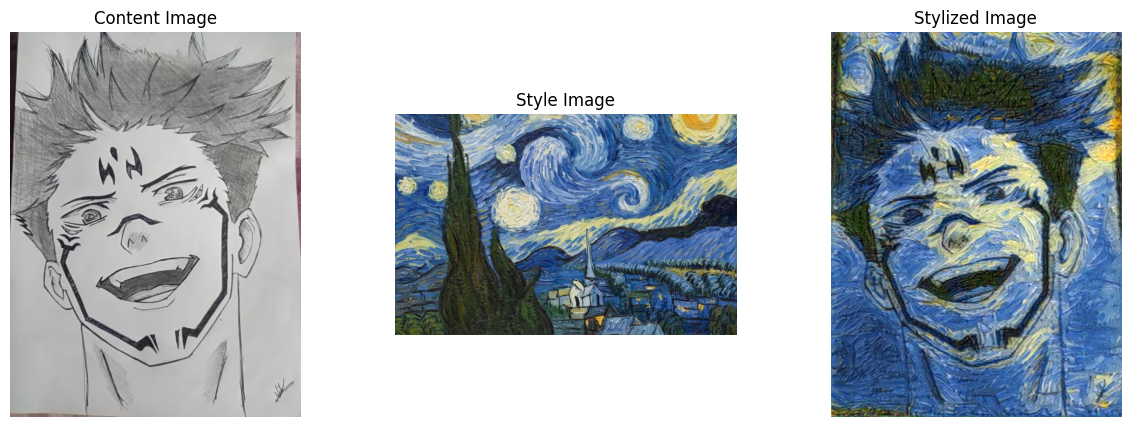

In [ ]:
run_style_transfer('/content4.jpeg', '/style4.jpeg')

#Drawbacks and Scope for Improvement



*   **Addition of more loss functions** for example **Variation Loss**. After noticing that reducing only the style and content losses led to highly noisy outputs and to reduce that noise, I felt like we could also include total_loss of NST variation loss .
Similarly, we can define more loss functions that allow us to reach a better solution.


* Incorporating **quantitative metrics for assessing image quality** and **style transfer fidelity** could help in objectively evaluating the model's performance, right now its more of an eye test.

*  **Fine-Tuning** the weights assigned to different layers for style loss, which are somewhat arbitrary, will lead to better style transfer results.

* Instead of VGG, using **newer architectures** like ResNet, or other networks optimized for style transfer could yield better results.

* Experimenting with **different optimizers** or **learning rate** schedules might help in converging faster or avoiding local minima during optimization.


* Computational inefficiency as I couldn't run many epochs on my laptop but the availability of a better GPU would result in more epochs and better results.



